In [15]:
import numpy as np, pandas as pd
from pandas import DataFrame, Series
%matplotlib inline
%config InlineBackend.figure_format='svg'
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
x_train = pd.read_csv('train_fixed.csv')
x_test = pd.read_csv('test_fixed.csv')
y_train = pd.read_csv('y_train.csv', header=None).values[:,0]

In [17]:
x_train = x_train.values
x_test = x_test.values

# ridge

In [21]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

In [22]:
def ridge_test(alpha):
    reg = make_pipeline(RobustScaler(), Ridge(alpha=alpha))
    score = np.sqrt(-cross_val_score(reg, x_train, y_train, scoring='neg_mean_squared_error', cv=10)).mean()
    return score

In [23]:
ridge_scores = []
alphas = list(range(1,30))+[40,50,60]
for alpha in alphas:
    ridge_scores.append(ridge_test(alpha))

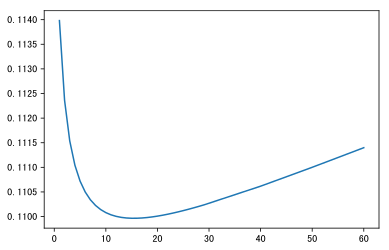

In [24]:
plt.plot(alphas, ridge_scores)

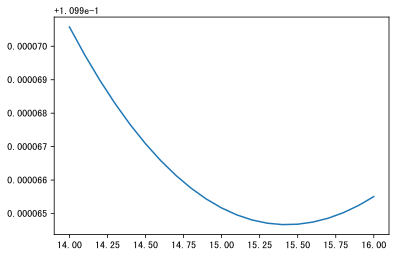

In [25]:
ridge_scores = []
for alpha in np.linspace(14, 16, 21):  # (14, 16, 21)
    ridge_scores.append(ridge_test(alpha))
plt.plot(np.linspace(14, 16, 21), ridge_scores)

In [26]:
min(ridge_scores)

0.10996466827553208

In [132]:
ridge = make_pipeline(RobustScaler(), Ridge(alpha=15.2))

# Lasso

In [135]:
from sklearn.linear_model import Lasso

In [136]:
'''lasso_scores = []
def lasso_test(alpha):
    lasso = make_pipeline(RobustScaler(), Lasso(alpha=alpha, max_iter=1e7))
    lasso_scores.append(\
        np.sqrt(-cross_val_score(lasso, x_train, y_train, cv=5, scoring='neg_mean_squared_error')).mean())'''

"lasso_scores = []\ndef lasso_test(alpha):\n    lasso = make_pipeline(RobustScaler(), Lasso(alpha=alpha, max_iter=1e7))\n    lasso_scores.append(        np.sqrt(-cross_val_score(lasso, x_train, y_train, cv=5, scoring='neg_mean_squared_error')).mean())"

In [137]:
'''alphas = [0.00005, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
for alpha in alphas:
    lasso_test(alpha)
plt.plot(alphas, lasso_scores)'''

'alphas = [0.00005, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]\nfor alpha in alphas:\n    lasso_test(alpha)\nplt.plot(alphas, lasso_scores)'

In [138]:
'''min(lasso_scores)'''

'min(lasso_scores)'

In [139]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0004, max_iter=1e7))

# xgb

In [140]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

In [141]:
'''gsearch = GridSearchCV(estimator = XGBRegressor(),
                      param_grid={
                          'max_depth':[3,4,5],
                          'subsample':[0.5,0.6,0.7],
                          'colsample_bytree':[0.5,0.6,0.7],
                          'min_child_weight':[0,1,2],
                          'gamma':[0,0.003,0.005],
                          'seed':list(range(20))
                      },
                      scoring='neg_mean_squared_error',
                      cv=5)
                      '''

"gsearch = GridSearchCV(estimator = XGBRegressor(),\n                      param_grid={\n                          'max_depth':[3,4,5],\n                          'subsample':[0.5,0.6,0.7],\n                          'colsample_bytree':[0.5,0.6,0.7],\n                          'min_child_weight':[0,1,2],\n                          'gamma':[0,0.003,0.005],\n                          'seed':list(range(20))\n                      },\n                      scoring='neg_mean_squared_error',\n                      cv=5)\n                      "

In [142]:
xgb = make_pipeline(RobustScaler(), XGBRegressor(learning_rate =0.01, n_estimators=3500, max_depth=3,
                     min_child_weight=0 , gamma=0, subsample=0.6,
                     colsample_bytree=0.6, reg_alpha=0, seed=17))

# stacking

In [143]:
from mlxtend.regressor import StackingCVRegressor

In [144]:
stack = StackingCVRegressor(regressors=(ridge, lasso, xgb), meta_regressor=xgb, use_features_in_secondary=True)

In [145]:
ridge.fit(x_train, y_train)
y_ridge = np.expm1(ridge.predict(x_test))

In [146]:
lasso.fit(x_train, y_train)
y_lasso = np.expm1(lasso.predict(x_test))

In [147]:
xgb.fit(x_train, y_train)
y_xgb = np.expm1(xgb.predict(x_test))

In [148]:
stack.fit(x_train, y_train)
y_stack = np.expm1(stack.predict(x_test))

In [149]:
predict = 0.5*y_stack + 0.1*y_ridge + 0.2*y_lasso + 0.2*y_xgb

In [155]:
price_pred = DataFrame({'Id':list(range(1461,2920)), 'SalePrice':predict})

In [156]:
price_pred.to_csv('pred', index=False)